In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [155]:
data = pd.read_csv("input_data.csv")

In [156]:
original_data = data.copy()
original_data = original_data.dropna()

In [157]:
original_data.head(1)

,inbnd_type,warehouse_name,supplier_id,product_id,sku_name,sku_weight_kg,sku_volume_litr,sku_type,accepted_weight_kg,accepted_volume_litr,...,start_day,start_week,start_weekday,inbnd_duration_min_kg,storage_condition_code,fragile_flg,sku_category_level_1_nm,sku_category_level_2_nm,sku_category_level_3_nm,sku_category_level_4_nm
0,Кросс-док,РЦ СБЛ ВЛГ-2 WMS,c7a48c69-0381-11e9-80c5-0cc47a817925,82cccfb1-7f28-11eb-85a3-1c34dae33151,"Сырок творожный Простоквашино глазированный, в...",0.041,0.143,piece,1.476,5.148,...,26,22,1,35.620724,MEDIUM_COLD,0,Молочная продукция,Молочно-десертные продукты,Сырки глазированные,Сырки глазированные классические


## Деление выборки

In [158]:
x = data.drop('inbnd_duration_min_kg', axis=1)
y = data['inbnd_duration_min_kg']

In [159]:
x_train, x_test, y_train, y_test = train_test_split(
    x , y, test_size=0.2, random_state=42, stratify=None
)

In [160]:
test_indices = x_test.index

### Преобразование данных

In [161]:
len(x_train)

93279

In [162]:
len(x_test)

23320

In [163]:
x_train['started_at'] = pd.to_datetime(x_train['started_at'])
x_train['start_hour'] = x_train['start_hour'].astype(str)
x_train['start_day'] = x_train['start_day'].astype(str)
x_train['start_week'] = x_train['start_week'].astype(str)
x_train['start_weekday'] = x_train['start_weekday'].astype(str)
x_train['fragile_flg'] = x_train['fragile_flg'].astype(str)

x_test['started_at'] = pd.to_datetime(x_test['started_at'])
x_test['start_hour'] = x_test['start_hour'].astype(str)
x_test['start_day'] = x_test['start_day'].astype(str)
x_test['start_week'] = x_test['start_week'].astype(str)
x_test['start_weekday'] = x_test['start_weekday'].astype(str)
x_test['fragile_flg'] = x_test['fragile_flg'].astype(str)

In [164]:
def handle_missing_data(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        df[col].fillna(df[col].median(), inplace=True)
    
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col].fillna('Unknown', inplace=True)
    
    return df

In [165]:
def encode_categorical_features(df):
    le = LabelEncoder()
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col].astype(str))
    
    return df

In [166]:
x_test.dtypes

inbnd_type                         object
warehouse_name                     object
supplier_id                        object
product_id                         object
sku_name                           object
sku_weight_kg                     float64
sku_volume_litr                   float64
sku_type                           object
accepted_weight_kg                float64
accepted_volume_litr              float64
started_at                 datetime64[ns]
start_hour                         object
start_day                          object
start_week                         object
start_weekday                      object
storage_condition_code             object
fragile_flg                        object
sku_category_level_1_nm            object
sku_category_level_2_nm            object
sku_category_level_3_nm            object
sku_category_level_4_nm            object
dtype: object

In [167]:
x_test = handle_missing_data(x_test)
x_test = encode_categorical_features(x_test)

x_train = handle_missing_data(x_train)
x_train = encode_categorical_features(x_train)

In [168]:
def drop_colums(df):
    df = df.drop(['started_at','accepted_weight_kg','accepted_volume_litr'], axis=1)
    return df

In [169]:
x_test = drop_colums(x_test)
x_train = drop_colums(x_train)

In [170]:
x_train

,inbnd_type,warehouse_name,supplier_id,product_id,sku_name,sku_weight_kg,sku_volume_litr,sku_type,start_hour,start_day,start_week,start_weekday,storage_condition_code,fragile_flg,sku_category_level_1_nm,sku_category_level_2_nm,sku_category_level_3_nm,sku_category_level_4_nm
113833,0,8,75,365,491,0.035,0.132000,0,11,4,12,2,2,0,1,14,11,28
3653,0,1,79,156,11,7.020,20.700000,0,11,22,24,0,3,1,10,0,3,2
53334,0,3,83,147,622,0.288,0.689920,0,19,16,27,0,2,1,3,2,51,140
95255,0,6,48,691,221,1.005,1.842375,0,18,29,10,4,2,0,4,6,23,47
43936,0,0,75,370,414,0.102,0.196065,0,18,2,16,3,2,0,1,14,86,166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76820,0,2,83,256,536,0.217,0.672966,0,6,5,16,6,2,0,3,2,63,119
110268,0,0,33,340,605,0.545,1.641600,0,18,0,19,2,2,0,8,17,45,80
103694,0,7,26,619,100,0.500,1.500000,0,21,18,28,2,0,1,10,25,68,27
860,0,2,27,798,547,0.209,0.365625,0,6,4,16,5,2,1,3,2,63,119


## Обучение модели

In [171]:
# 5. МАСШТАБИРОВАНИЕ ЧИСЛОВЫХ ПРИЗНАКОВ (опционально для LightGBM, но может помочь)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

In [172]:
params = {
    'boosting_type': 'gbdt',          # тип бустинга
    'objective': 'regression',        # задача регрессии
    'metric': 'mae',                  # метрика - средняя абсолютная ошибка
    'num_leaves': 31,                 # максимальное количество листьев в дереве
    'learning_rate': 0.05,            # скорость обучения
    'feature_fraction': 0.9,          # доля признаков для использования на каждой итерации
    'bagging_fraction': 0.8,          # доля данных для использования на каждой итерации
    'bagging_freq': 5,                # частота bagging
    'verbose': 0,                     # уровень детализации вывода
    'random_state': 42,               # для воспроизводимости
    'n_estimators': 1000,             # количество деревьев
    'max_depth': -1,                  # глубина деревьев (-1 = без ограничений)
    'min_data_in_leaf': 20,           # минимальное количество данных в листе
}

In [173]:
train_data = lgb.Dataset(X_train_scaled, label=y_train)
test_data = lgb.Dataset(X_test_scaled, label=y_test, reference=train_data)

In [174]:
# Обучение модели с ранней остановкой
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[test_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 6.25708
[200]	valid_0's l1: 5.89168
[300]	valid_0's l1: 5.65695
[400]	valid_0's l1: 5.49638
[500]	valid_0's l1: 5.40714
[600]	valid_0's l1: 5.3352
[700]	valid_0's l1: 5.29583
[800]	valid_0's l1: 5.27095
[900]	valid_0's l1: 5.24755
[1000]	valid_0's l1: 5.22626
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 5.22626


In [175]:
y_pred = model.predict(X_test_scaled)

In [176]:
len(y_test)

23320

In [177]:
# Метрики качества
print(f"MAE (Средняя абсолютная ошибка): {mean_absolute_error(y_test, y_pred):.2f} минут")
print(f"MSE (Средняя квадратичная ошибка): {mean_squared_error(y_test, y_pred):.2f}")
print(f"RMSE (Корень из MSE): {np.sqrt(mean_squared_error(y_test, y_pred)):.2f} минут")
print(f"R² (Коэффициент детерминации): {r2_score(y_test, y_pred):.4f}")

MAE (Средняя абсолютная ошибка): 5.23 минут
MSE (Средняя квадратичная ошибка): 185.41
RMSE (Корень из MSE): 13.62 минут
R² (Коэффициент детерминации): 0.5496


## Важность признаков

In [178]:
# 8. ВАЖНОСТЬ ПРИЗНАКОВ
feature_importance = pd.DataFrame({
    'feature': x_train.columns,
    'importance': model.feature_importance()
}).sort_values('importance', ascending=False)

print("\nТОП-15 ВАЖНЕЙШИХ ПРИЗНАКОВ:")
print(feature_importance.head(15))


ТОП-15 ВАЖНЕЙШИХ ПРИЗНАКОВ:
                    feature  importance
3                product_id        3905
10               start_week        3236
5             sku_weight_kg        2969
9                 start_day        2870
1            warehouse_name        2743
4                  sku_name        2540
8                start_hour        2292
11            start_weekday        1953
6           sku_volume_litr        1919
2               supplier_id        1880
17  sku_category_level_4_nm        1227
16  sku_category_level_3_nm         815
15  sku_category_level_2_nm         656
14  sku_category_level_1_nm         390
0                inbnd_type         313


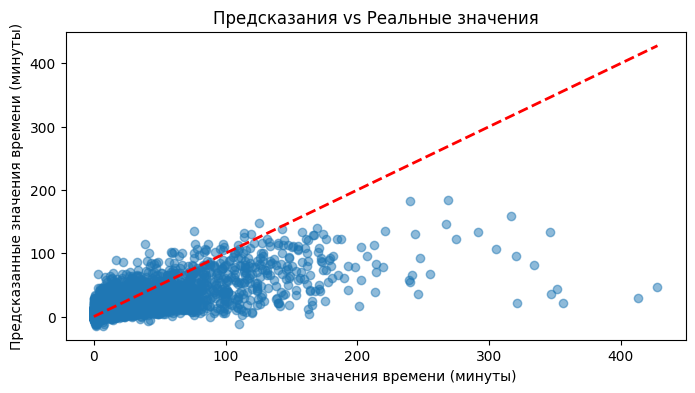

In [179]:
# 9. ВИЗУАЛИЗАЦИЯ ПРЕДСКАЗАНИЙ vs РЕАЛЬНЫЕ ЗНАЧЕНИЯ
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Реальные значения времени (минуты)')
plt.ylabel('Предсказанные значения времени (минуты)')
plt.title('Предсказания vs Реальные значения')
plt.show()

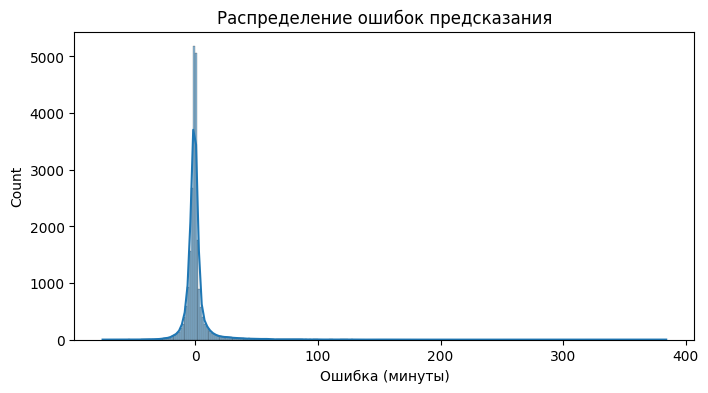

In [180]:
# 10. АНАЛИЗ ОШИБОК
errors = y_test - y_pred
plt.figure(figsize=(8, 4))
sns.histplot(errors, kde=True)
plt.title('Распределение ошибок предсказания')
plt.xlabel('Ошибка (минуты)')
plt.show()

In [182]:
# Создаем DataFrame с результатами
#results_df = x_test.copy()
results_df = original_data.loc[test_indices].copy()

# Добавляем предсказания и фактические значения
results_df['predicted_time'] = y_pred
results_df['actual_time'] = y_test

# Вычисляем ошибку
results_df['error'] = results_df['actual_time'] - results_df['predicted_time']
results_df['absolute_error'] = abs(results_df['error'])

# Сохраняем в CSV
results_df.to_csv('predictions_results.csv', index=False, encoding='utf-8-sig',sep='|')

print("Файл сохранен: predictions_results.csv")
print(f"Количество строк: {len(results_df)}")
print(f"Средняя ошибка: {results_df['absolute_error'].mean():.2f} минут")

Файл сохранен: predictions_results.csv
Количество строк: 23320
Средняя ошибка: 5.23 минут
